In [291]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as rg
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
path = os.path.join("House")
def load_csv(path,filename):
    return pd.read_csv(os.path.join(filename))


In [3]:
train_data = load_csv(path,"train.csv")
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
def relative_attribute_sale(attribute,train_data):
    return pd.DataFrame(train_data.groupby(by= attribute)['SalePrice'].mean().reset_index().sort_values(by = "SalePrice",ascending = True))

## Missing percent

In [6]:
na_list = set([i if len(set(train_data[i].isna())) == 2 else 0 for i in list(train_data)])
na_list.remove(0)
print(na_list)

{'BsmtFinType1', 'GarageQual', 'FireplaceQu', 'GarageFinish', 'GarageYrBlt', 'Fence', 'GarageCond', 'BsmtExposure', 'MasVnrType', 'PoolQC', 'Electrical', 'Alley', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'GarageType', 'MiscFeature', 'LotFrontage', 'BsmtFinType2'}


Garage,Fence,Bsmt,alley,MasVnr,Misc,

In [7]:
percent_nan = {}
for attribute in na_list:
    percent_nan[attribute] = (train_data[attribute].isna().sum() / train_data[attribute].shape[0])*100
print(percent_nan)

{'BsmtFinType1': 2.5342465753424657, 'GarageQual': 5.5479452054794525, 'FireplaceQu': 47.26027397260274, 'GarageFinish': 5.5479452054794525, 'GarageYrBlt': 5.5479452054794525, 'Fence': 80.75342465753424, 'GarageCond': 5.5479452054794525, 'BsmtExposure': 2.6027397260273974, 'MasVnrType': 0.547945205479452, 'PoolQC': 99.52054794520548, 'Electrical': 0.0684931506849315, 'Alley': 93.76712328767123, 'MasVnrArea': 0.547945205479452, 'BsmtQual': 2.5342465753424657, 'BsmtCond': 2.5342465753424657, 'GarageType': 5.5479452054794525, 'MiscFeature': 96.30136986301369, 'LotFrontage': 17.73972602739726, 'BsmtFinType2': 2.6027397260273974}


In [8]:
garage_percent = percent_nan['GarageCond']
temp_percent_nan = percent_nan.copy()
for key,value in temp_percent_nan.items():
    if rg.findall("Garage",key):
        percent_nan.pop(key)
percent_nan['Garage'] = garage_percent

In [9]:
percent_nan

{'BsmtFinType1': 2.5342465753424657,
 'FireplaceQu': 47.26027397260274,
 'Fence': 80.75342465753424,
 'BsmtExposure': 2.6027397260273974,
 'MasVnrType': 0.547945205479452,
 'PoolQC': 99.52054794520548,
 'Electrical': 0.0684931506849315,
 'Alley': 93.76712328767123,
 'MasVnrArea': 0.547945205479452,
 'BsmtQual': 2.5342465753424657,
 'BsmtCond': 2.5342465753424657,
 'MiscFeature': 96.30136986301369,
 'LotFrontage': 17.73972602739726,
 'BsmtFinType2': 2.6027397260273974,
 'Garage': 5.5479452054794525}

In [10]:
percent_nan = pd.DataFrame.from_dict(percent_nan,orient='index').reset_index().rename({'index':'Name',0:'Missing Percent'},axis=1)


In [11]:
percent_nan.sort_values(by = 'Missing Percent',inplace=True)

In [12]:
percent_nan

,Name,Missing Percent
6,Electrical,0.068493
4,MasVnrType,0.547945
8,MasVnrArea,0.547945
0,BsmtFinType1,2.534247
9,BsmtQual,2.534247
10,BsmtCond,2.534247
3,BsmtExposure,2.602740
13,BsmtFinType2,2.602740
14,Garage,5.547945
12,LotFrontage,17.739726


<AxesSubplot:title={'center':'Missing percent'}, xlabel='Name', ylabel='Missing Percent'>

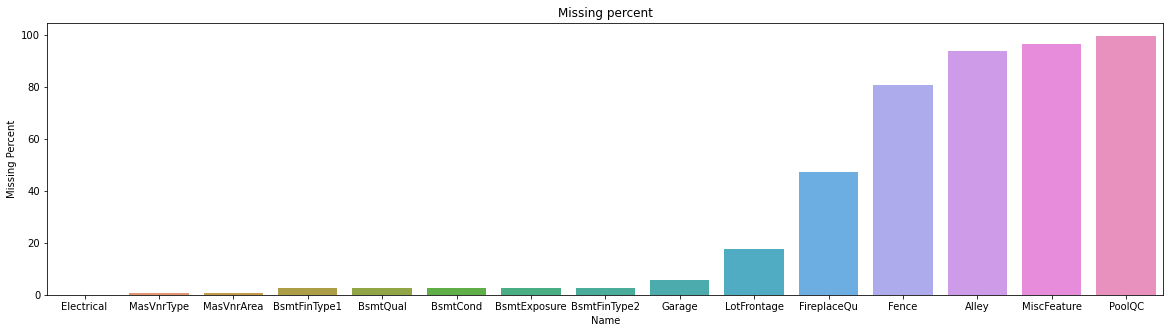

In [13]:
plt.figure(figsize = (20,5))
plt.title("Missing percent")
sns.barplot(data = percent_nan,x='Name',y= 'Missing Percent',order = percent_nan['Name'])

In [14]:
def ScaleNotChangePrice(attribute,point_attribute,train_data= train_data):
    mean_price = train_data[train_data[attribute] == point_attribute]["SalePrice"].mean()
    interval = [mean_price-30000,mean_price+30000]
    return train_data[(train_data['SalePrice'] > interval[0]) & (train_data['SalePrice'] < interval[1])][attribute].mean()

### MSSUBCLASS


In [15]:
train_data['MSSubClass'].value_counts().index

Int64Index([20, 60, 50, 120, 30, 160, 70, 80, 90, 190, 85, 75, 45, 180, 40], dtype='int64')

In [16]:
train_data['MSSubClass'].value_counts(ascending=True).index

Int64Index([40, 180, 45, 75, 85, 190, 90, 80, 70, 160, 30, 120, 50, 60, 20], dtype='int64')

In [17]:
train_data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [18]:
train_data.groupby(by = 'MSSubClass')['SalePrice'].mean().sort_values(ascending = True).index

Int64Index([30, 180, 45, 190, 90, 160, 50, 85, 40, 70, 80, 20, 75, 120, 60], dtype='int64', name='MSSubClass')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

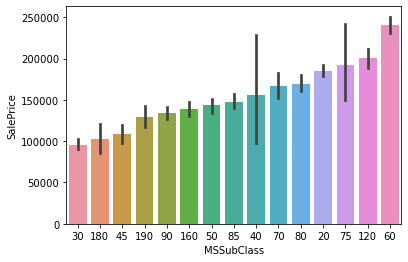

In [19]:
sns.barplot(data = train_data,x='MSSubClass',y='SalePrice',order = train_data.groupby(by = 'MSSubClass')['SalePrice'].mean().sort_values(ascending = True).index)

## MSZoning


In [20]:
train_data.groupby('MSZoning').mean().sort_values(by='SalePrice')['SalePrice']

MSZoning
C (all)     74528.000000
RM         126316.830275
RH         131558.375000
RL         191004.994787
FV         214014.061538
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

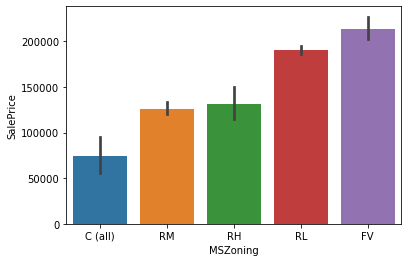

In [21]:
sns.barplot(data = train_data,x = 'MSZoning',y = 'SalePrice',order = train_data.groupby('MSZoning').mean().sort_values(by='SalePrice')['SalePrice'].index)

## LotFrontage: has NAN (use SimpleImputer)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

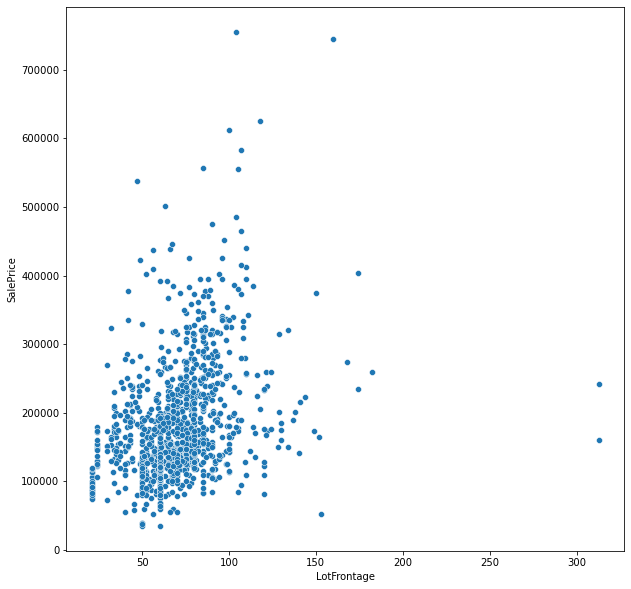

In [22]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

In [23]:
train_data['LotFrontage'] = train_data['LotFrontage'].apply(lambda x: ScaleNotChangePrice("LotFrontage",x) if x > 250 else x)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

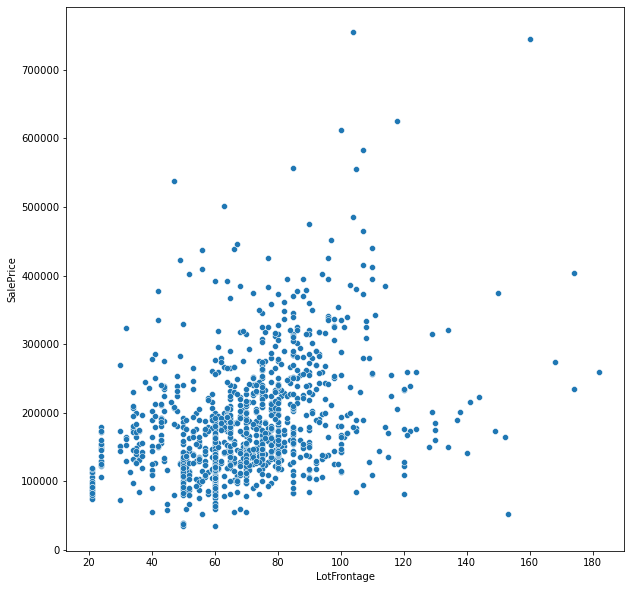

In [24]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

## Lot Area

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

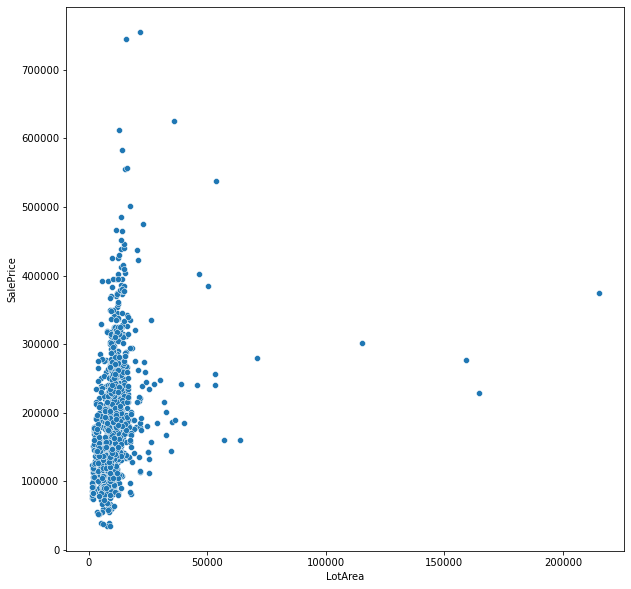

In [25]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

In [26]:
train_data['LotArea'] = train_data['LotArea'].apply(lambda x: ScaleNotChangePrice("LotArea",x) if x > 100000 else x) 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

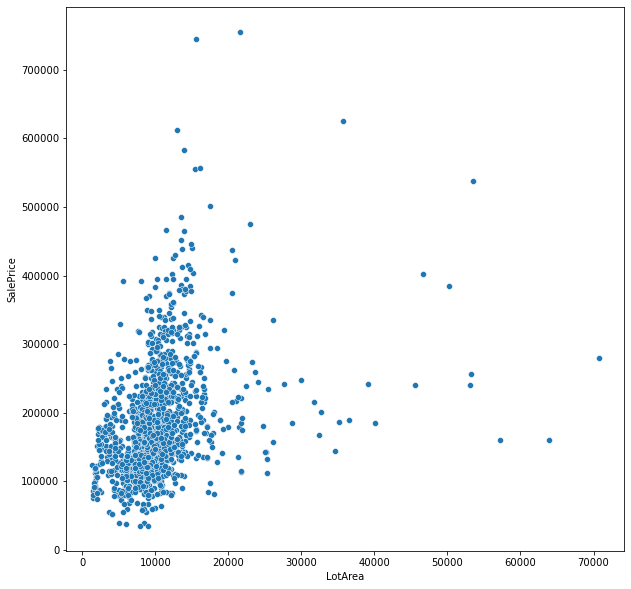

In [27]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

## Street

In [28]:
train_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

<AxesSubplot:xlabel='Street', ylabel='SalePrice'>

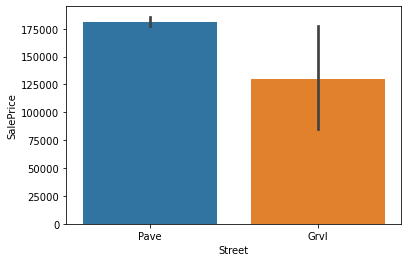

In [29]:
sns.barplot(data = train_data, x = 'Street',y='SalePrice')

## Alley: has NAN

In [30]:
train_data['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [31]:
len(train_data['Alley'].isna())

1460

In [32]:
train_data['Alley'] = train_data['Alley'].fillna("0")


<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

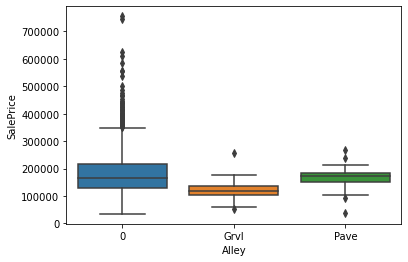

In [33]:
sns.boxplot(data = train_data,x = 'Alley',y='SalePrice')

## LotShape

In [34]:
train_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

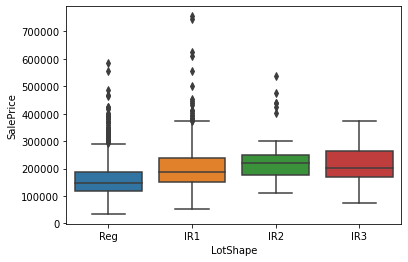

In [35]:
sns.boxplot(data = train_data,x = 'LotShape',y='SalePrice')

## LandContour

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

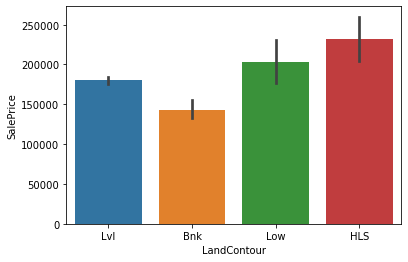

In [36]:
sns.barplot(data = train_data,x = 'LandContour',y='SalePrice')

## Utilities

In [264]:
train_data['Utilities'].value_counts() #????

Utilities    1460
Name: Utilities, dtype: int64

In [265]:
train_data['Utilities'] = train_data['Utilities'].apply(lambda x:"AllPub")

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice'>

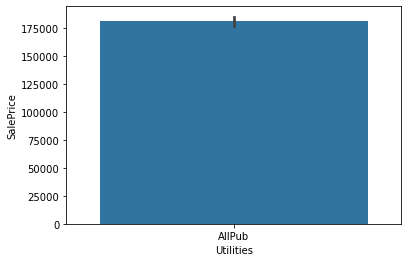

In [266]:
sns.barplot(data = train_data,x = 'Utilities',y='SalePrice')

## LotConfig

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

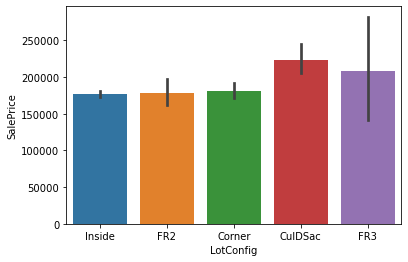

In [38]:
sns.barplot(data = train_data,x='LotConfig',y='SalePrice')

## LandSlope

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

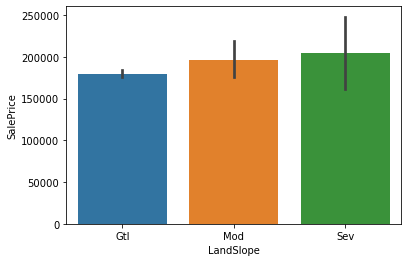

In [39]:
sns.barplot(data = train_data,x='LandSlope',y='SalePrice')

## Neighborhood

In [40]:
train_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

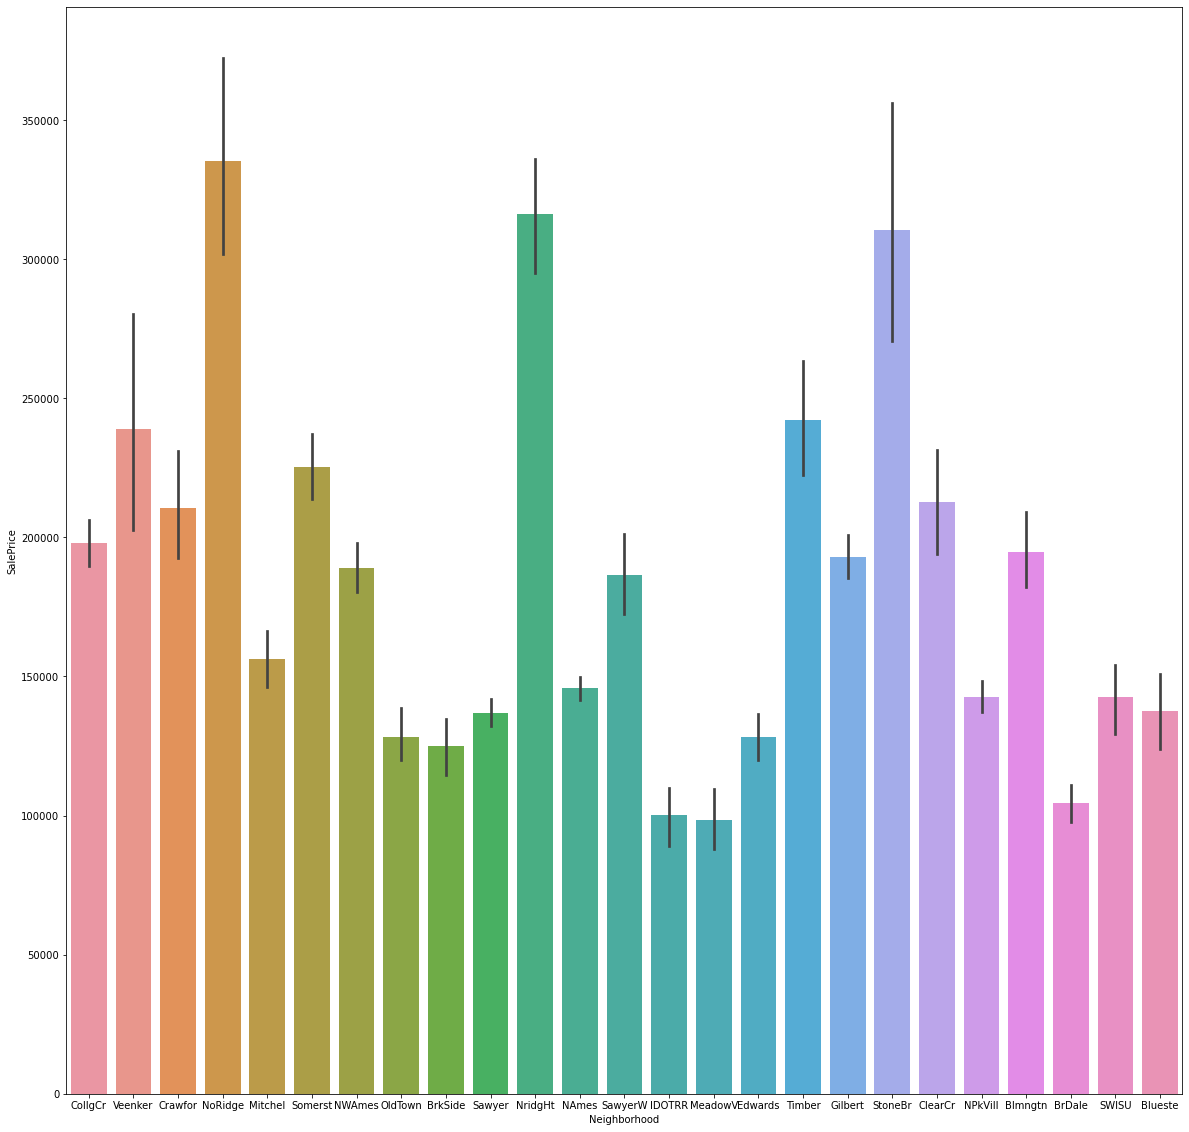

In [41]:
plt.figure(figsize = (20,20))
sns.barplot(data = train_data,x='Neighborhood',y='SalePrice')

group ?

## Condition1 + Condition2

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

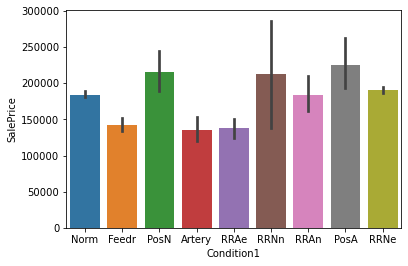

In [42]:
sns.barplot(data = train_data,x = 'Condition1',y='SalePrice')

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

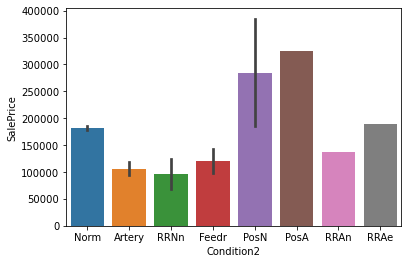

In [43]:
sns.barplot(data = train_data,x = 'Condition2',y='SalePrice')

## BldgType

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

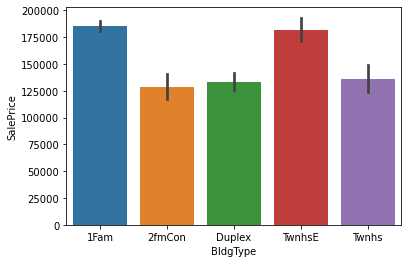

In [44]:
sns.barplot(data = train_data,x='BldgType',y = 'SalePrice')

## HouseStyle

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

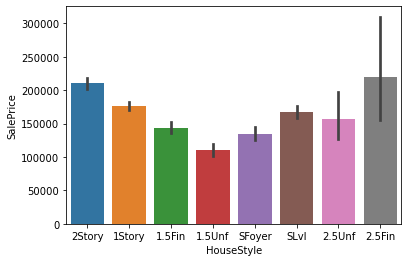

In [45]:
sns.barplot(data = train_data,x='HouseStyle',y = 'SalePrice')

## OverallQual + OverallCond

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

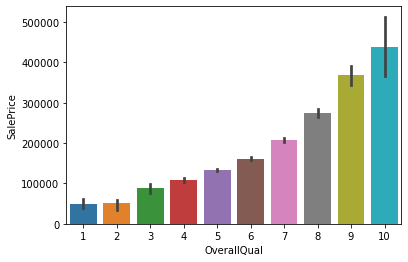

In [46]:
sns.barplot(data = train_data,x='OverallQual',y = 'SalePrice')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

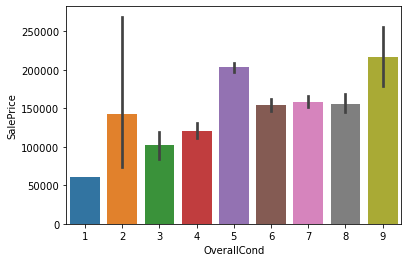

In [47]:
sns.barplot(data = train_data,x='OverallCond',y = 'SalePrice')

why 5 and 2 ? 

## Year Built 

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

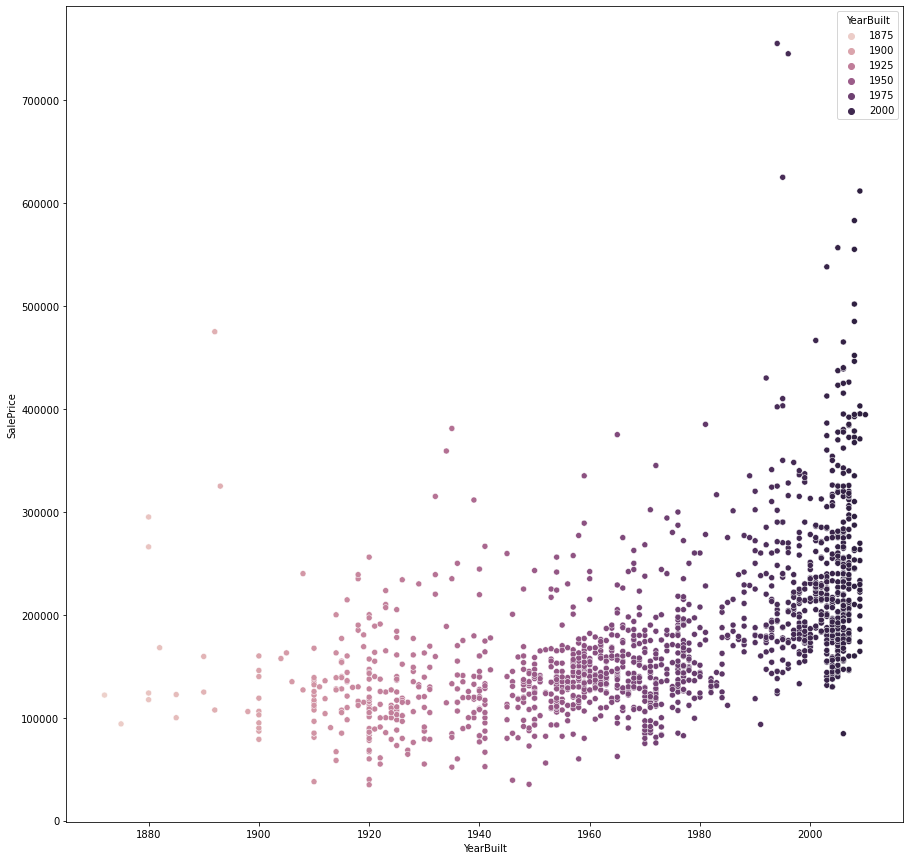

In [48]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearBuilt',y='SalePrice',hue = 'YearBuilt')

higher year => higher price

## YearRemodAdd

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

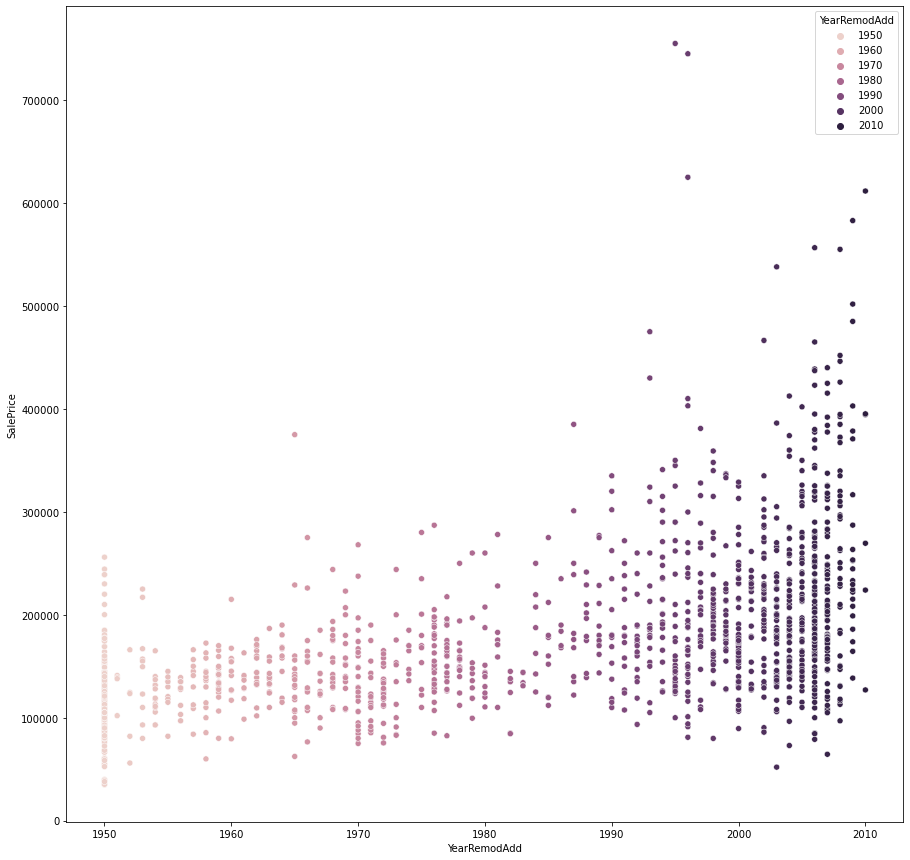

In [49]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearRemodAdd',y='SalePrice',hue = 'YearRemodAdd')

same as YearBuilt

## RoofStyle

In [50]:
train_data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

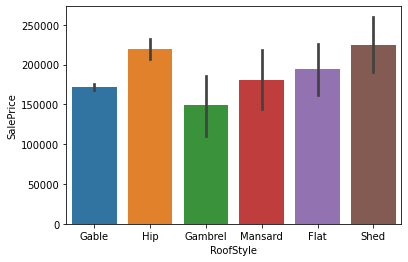

In [51]:
sns.barplot(data = train_data,x='RoofStyle',y='SalePrice')

## RoofMatl

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

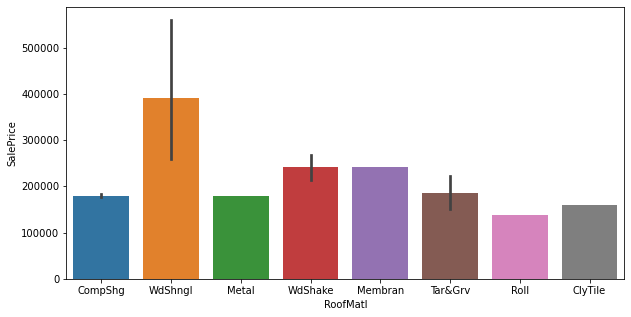

In [52]:
plt.figure(figsize = (10,5))
sns.barplot(data = train_data,x='RoofMatl',y='SalePrice')

## Exterior1st + 2nd

In [194]:
train_data['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

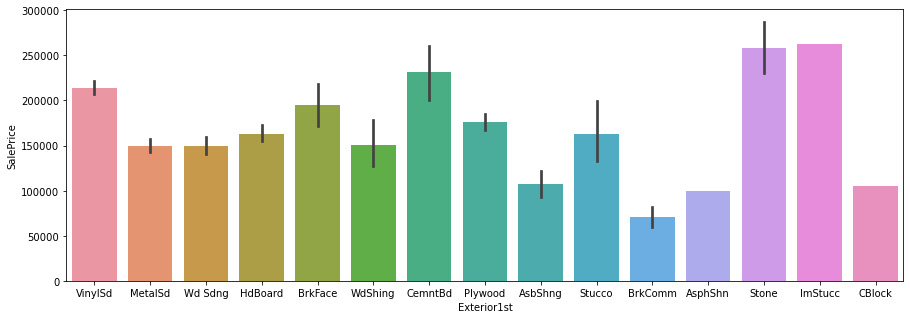

In [53]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior1st',y='SalePrice')

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

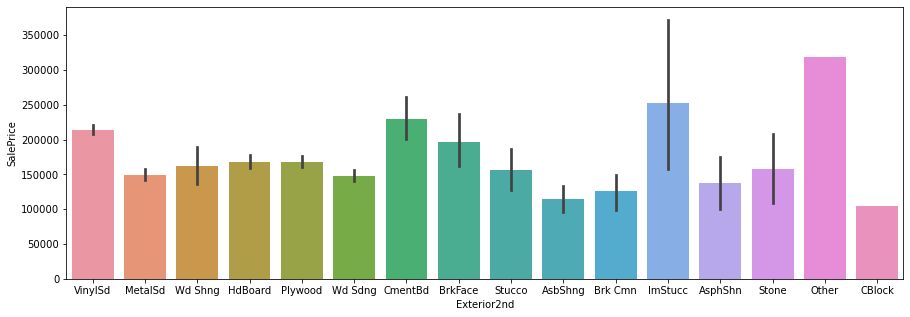

In [54]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior2nd',y='SalePrice')

## MasVnrType: has NAN

In [193]:
train_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
0            8
Name: MasVnrType, dtype: int64

In [56]:
train_data['MasVnrType'] = train_data['MasVnrType'].fillna("0")

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice'>

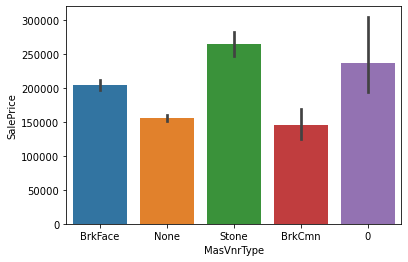

In [57]:
sns.barplot(data = train_data,x='MasVnrType',y='SalePrice')

## MasVnrArea: has NAN (simpleImputer)

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

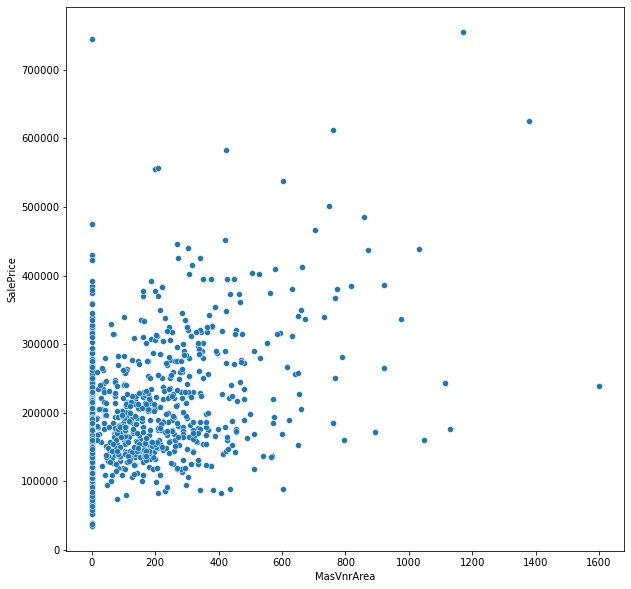

In [58]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MasVnrArea',y='SalePrice')

In [59]:
train_data['MasVnrArea'] = train_data['MasVnrArea'].apply(lambda x: ScaleNotChangePrice("MasVnrArea",x) if x > 1350 else x)

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

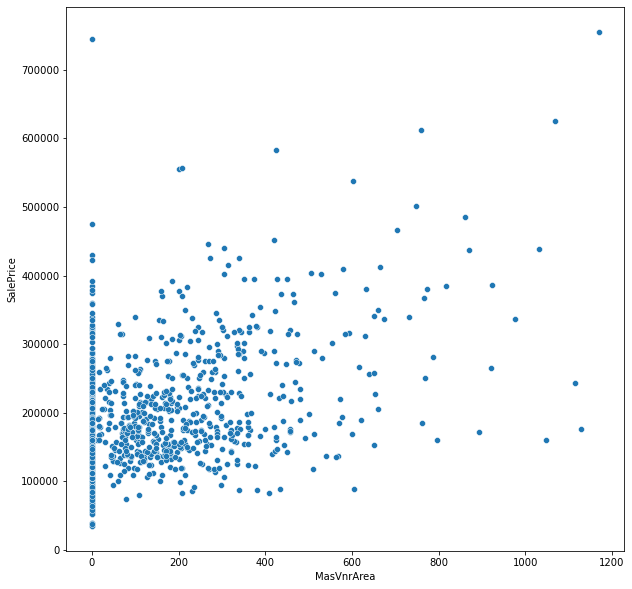

In [60]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MasVnrArea',y='SalePrice')

## ExterQual + ExterCond

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

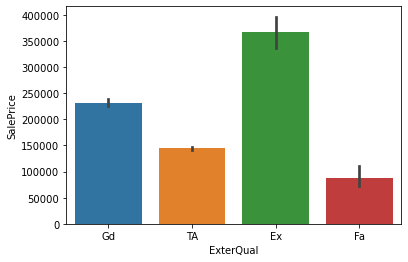

In [61]:
sns.barplot(data = train_data,x='ExterQual',y='SalePrice')

<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

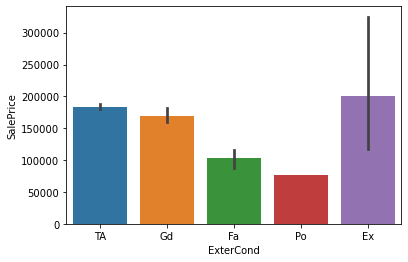

In [62]:
sns.barplot(data = train_data,x='ExterCond',y='SalePrice')

## Foundation

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

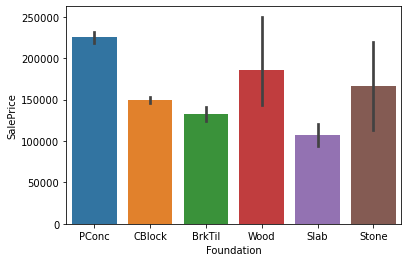

In [63]:
sns.barplot(data = train_data,x='Foundation',y='SalePrice')

## Basement: has NAN

### BsmtQual 

In [64]:
train_data['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [65]:
train_data['BsmtQual'] = train_data['BsmtQual'].fillna("0")

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

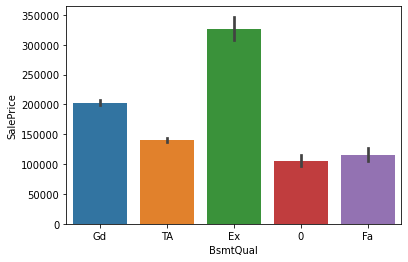

In [66]:
sns.barplot(data = train_data,x='BsmtQual',y='SalePrice')

### BsmtCond

In [67]:
train_data['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [68]:
train_data['BsmtCond'] = train_data['BsmtCond'].fillna("0")

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

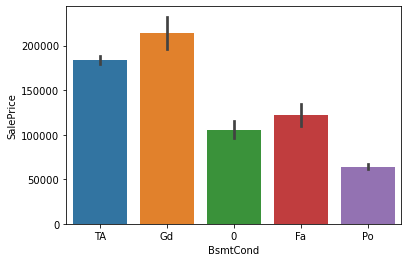

In [69]:
sns.barplot(data = train_data,x='BsmtCond',y='SalePrice')

### BsmtExposure

In [70]:
train_data['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [71]:
train_data['BsmtExposure'] = train_data['BsmtExposure'].fillna("0")

<AxesSubplot:xlabel='BsmtExposure', ylabel='SalePrice'>

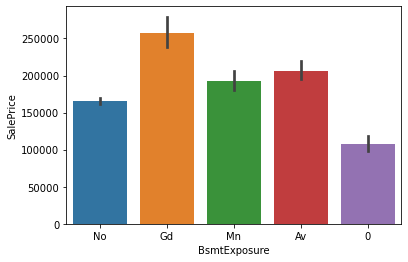

In [72]:
sns.barplot(data = train_data,x='BsmtExposure',y='SalePrice')

### BsmtFinType1

In [73]:
train_data['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [74]:
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna("0")

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice'>

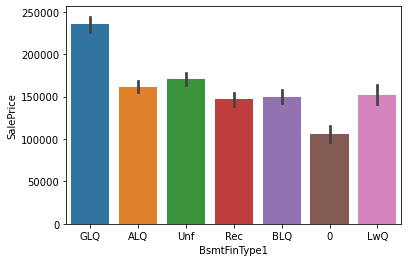

In [75]:
sns.barplot(data = train_data,x='BsmtFinType1',y='SalePrice')

### BsmtFinSF1

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

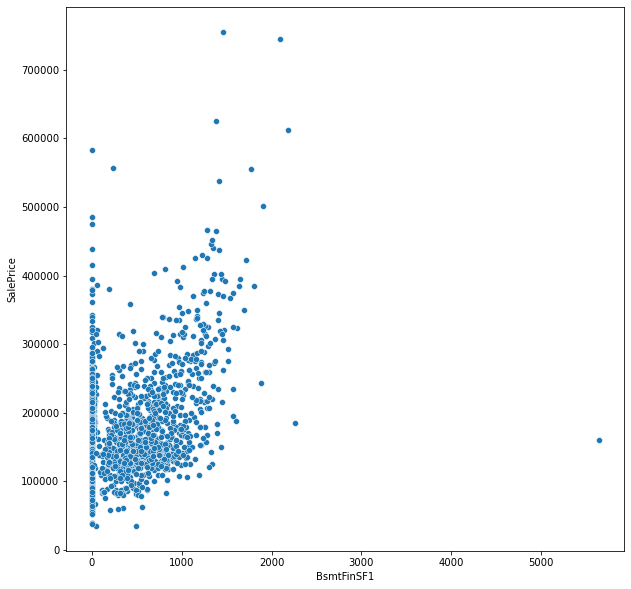

In [76]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=train_data,x='BsmtFinSF1',y='SalePrice')

In [77]:
train_data["BsmtFinSF1"] = train_data["BsmtFinSF1"].apply(lambda x: ScaleNotChangePrice("BsmtFinSF1",x) if x > 4000 else x)

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

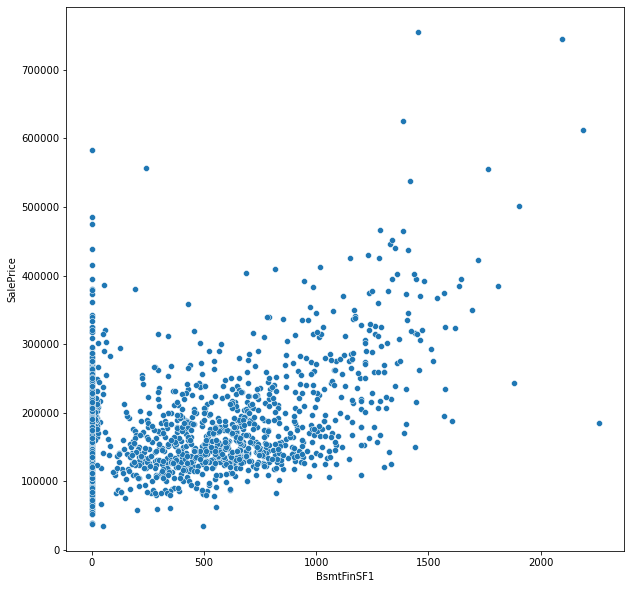

In [78]:
plt.figure(figsize = (10,10))
sns.scatterplot(data=train_data,x='BsmtFinSF1',y='SalePrice')

### BsmtFinType2

In [79]:
train_data['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [80]:
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].fillna("0")

<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice'>

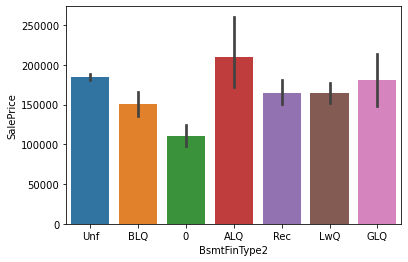

In [81]:
sns.barplot(data = train_data,x='BsmtFinType2',y='SalePrice')

### BsmtFinSF2

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice'>

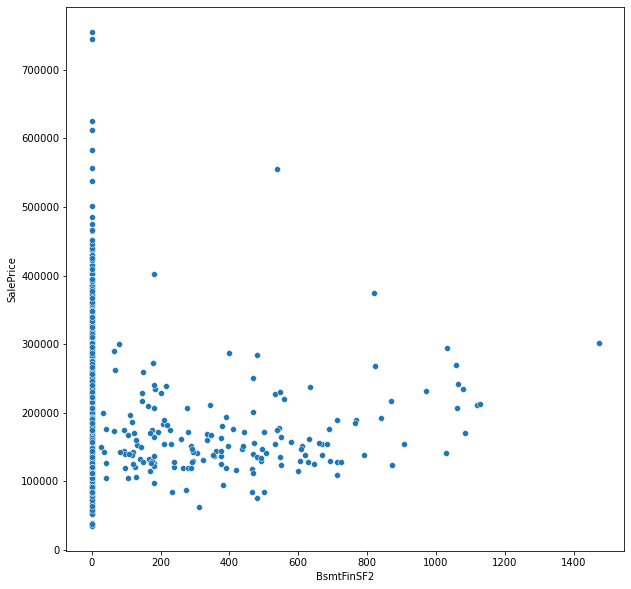

In [82]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtFinSF2',y = 'SalePrice')

In [83]:
train_data['BsmtFinSF2'] = train_data['BsmtFinSF2'].apply(lambda x: ScaleNotChangePrice("BsmtFinSF2",x) if x> 1300 else x)

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice'>

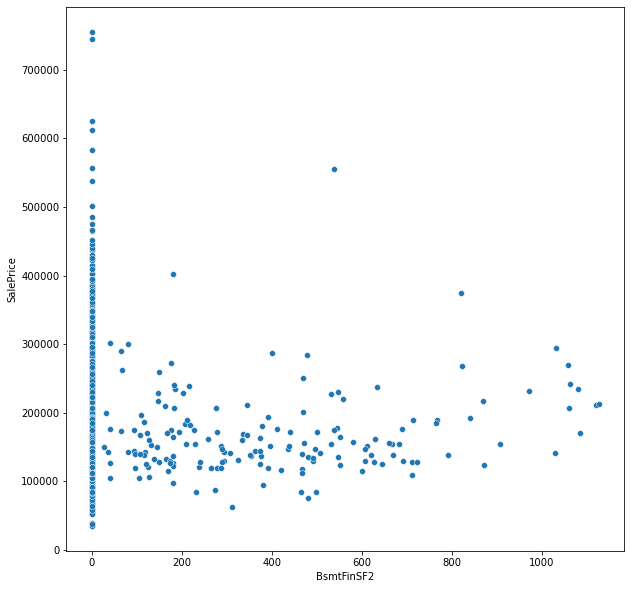

In [84]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtFinSF2',y = 'SalePrice')

### BsmtUnfSF

<AxesSubplot:xlabel='BsmtUnfSF', ylabel='SalePrice'>

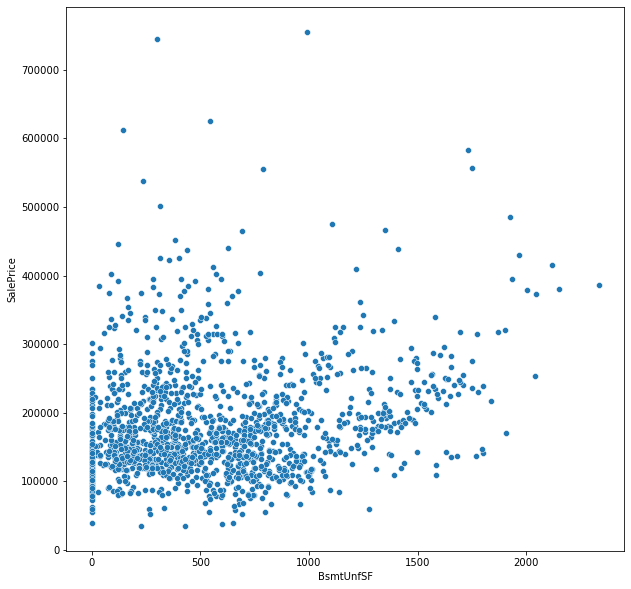

In [85]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='BsmtUnfSF',y='SalePrice')

how ??? 

### TotalBsmtSF

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

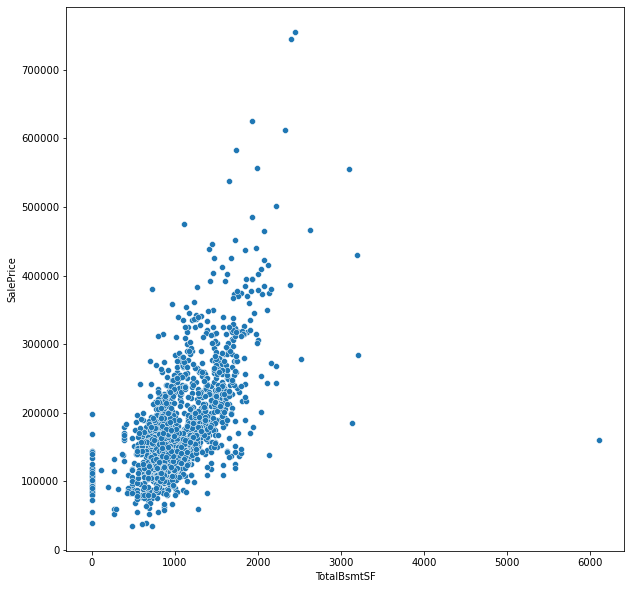

In [86]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='TotalBsmtSF',y='SalePrice')

In [87]:
train_data['TotalBsmtSF'] = train_data['TotalBsmtSF'].apply(lambda x: ScaleNotChangePrice('TotalBsmtSF',x) if x> 5500 else x)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

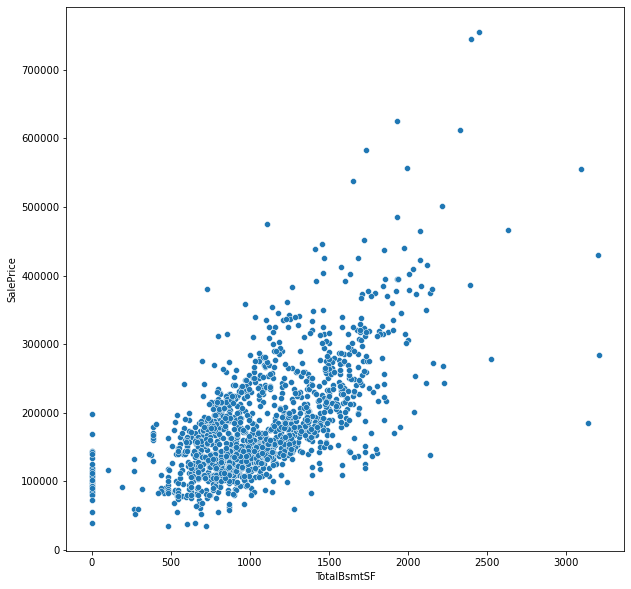

In [88]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='TotalBsmtSF',y='SalePrice')

## Heating

### Heating

<AxesSubplot:xlabel='Heating', ylabel='SalePrice'>

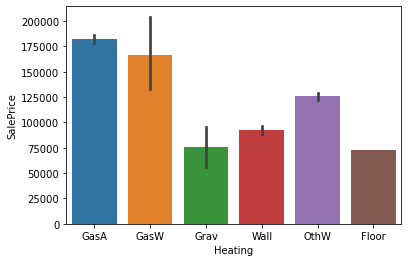

In [89]:
sns.barplot(data = train_data,x='Heating',y='SalePrice')

### HeatingQC

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

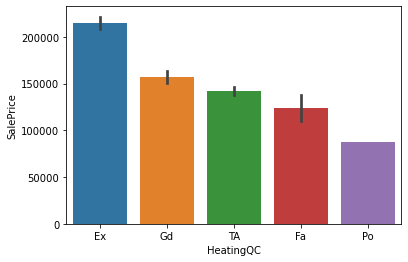

In [90]:
sns.barplot(data = train_data,x='HeatingQC',y='SalePrice')

## CentralAir

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

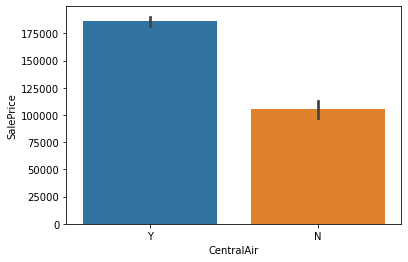

In [91]:
sns.barplot(data = train_data,x='CentralAir',y='SalePrice')

## Electrical

In [92]:
train_data['Electrical'].fillna(train_data['Electrical'].value_counts().index[0],inplace=True)

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

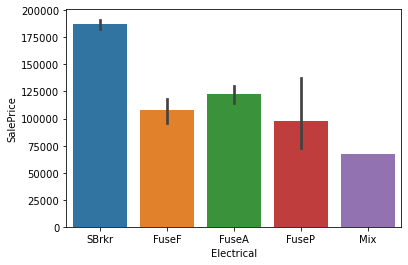

In [93]:
sns.barplot(data = train_data,x='Electrical',y='SalePrice')

## 1stFlrSF

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

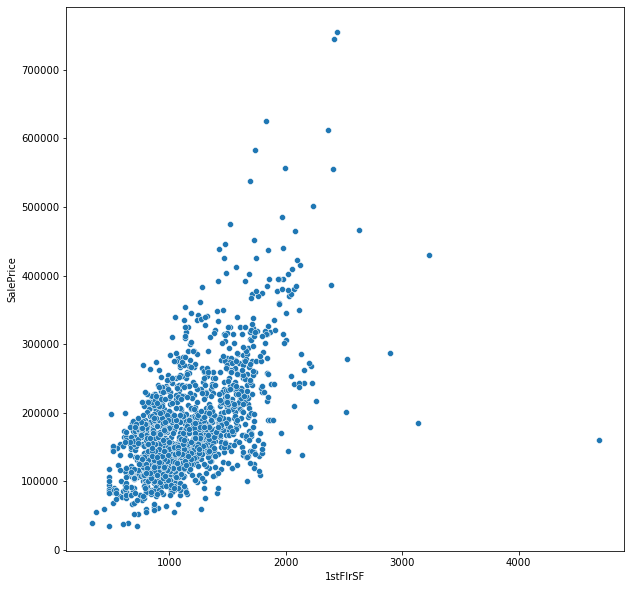

In [94]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='1stFlrSF',y='SalePrice')

In [95]:
train_data['1stFlrSF'] = train_data['1stFlrSF'].apply(lambda x:ScaleNotChangePrice('1stFlrSF',x) if x> 4000 else x)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

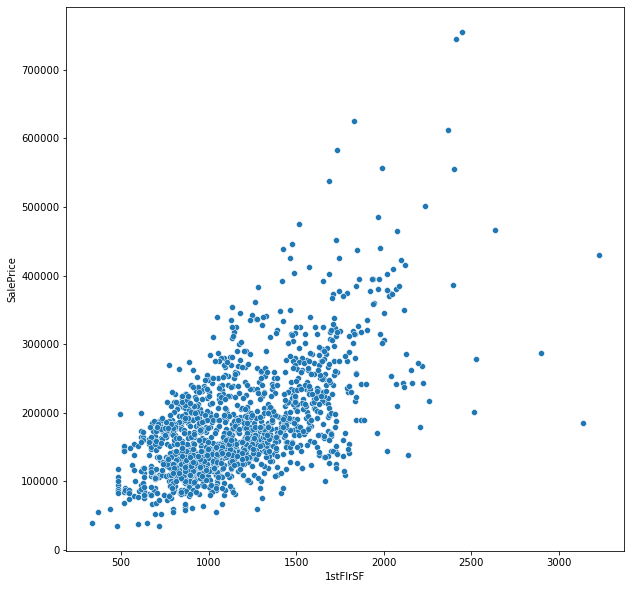

In [96]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='1stFlrSF',y='SalePrice')

## 2ndFlrSF

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

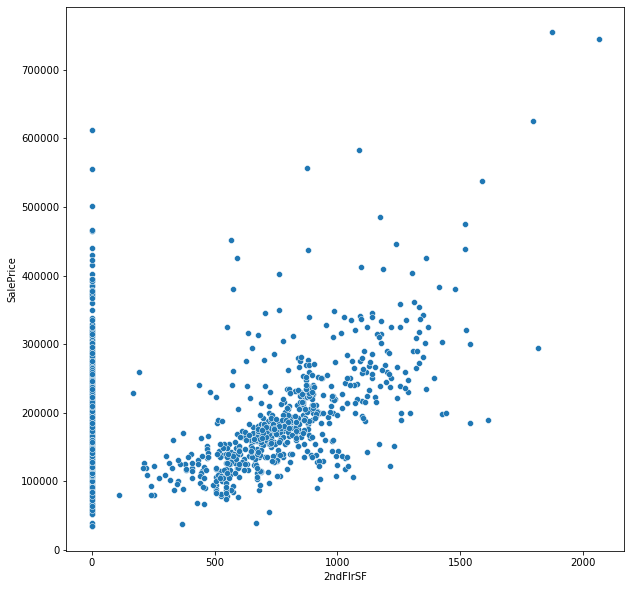

In [97]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='2ndFlrSF',y='SalePrice')

## LowQualFinSF

<AxesSubplot:xlabel='LowQualFinSF', ylabel='SalePrice'>

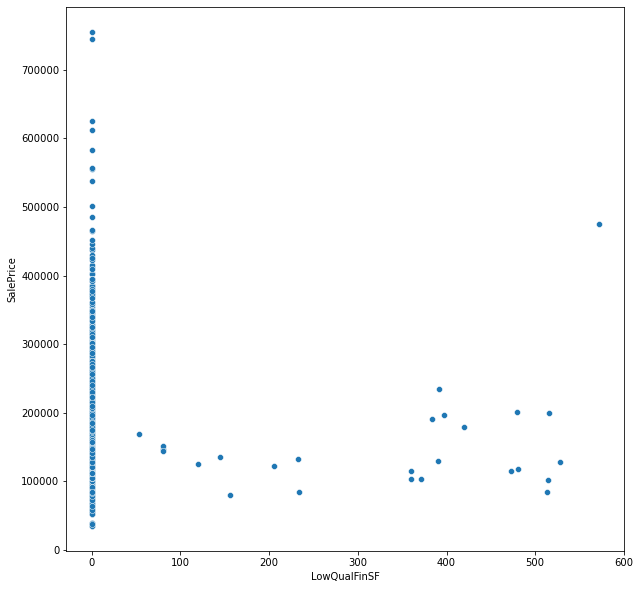

In [98]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='LowQualFinSF',y='SalePrice')

## GrLivArea

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

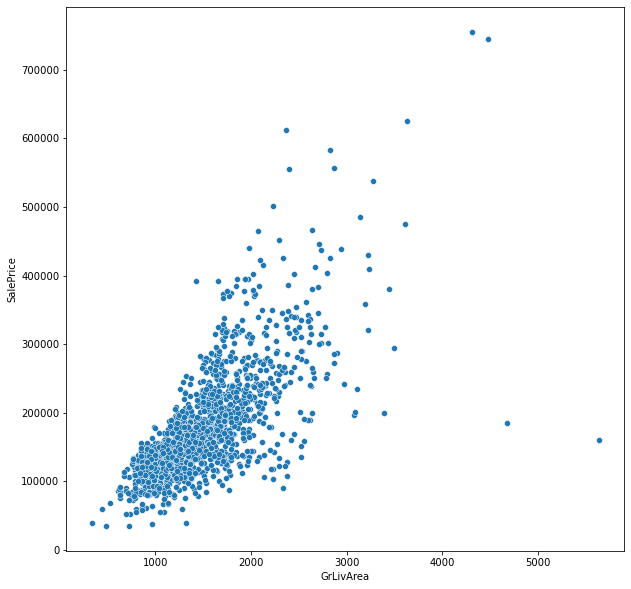

In [99]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GrLivArea',y='SalePrice')

In [100]:
train_data['GrLivArea'] = train_data['GrLivArea'].apply(lambda x: ScaleNotChangePrice('GrLivArea',x) if x > 4500 else x)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

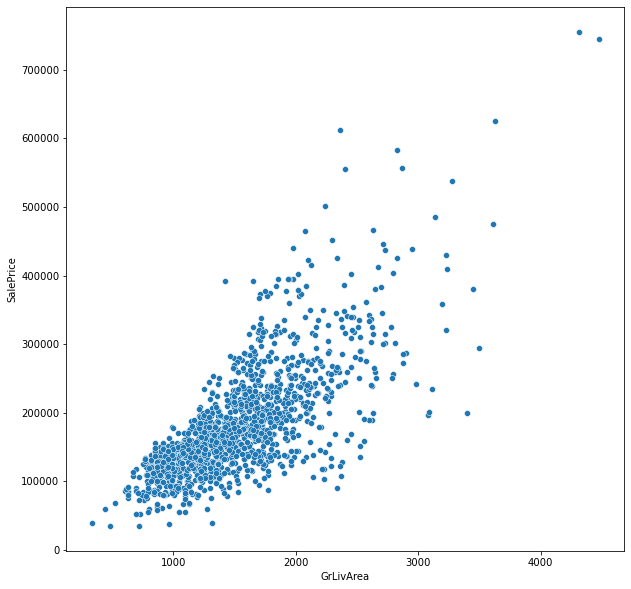

In [101]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GrLivArea',y='SalePrice')

## Bathroom

### BsmtFullBath

In [102]:
train_data['BsmtFullBath'].value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

<AxesSubplot:xlabel='BsmtFullBath', ylabel='SalePrice'>

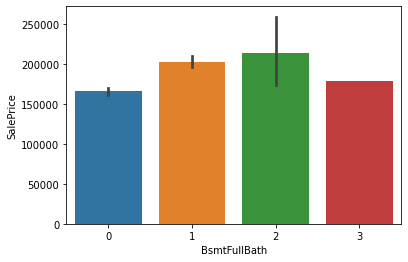

In [103]:
sns.barplot(data = train_data,x='BsmtFullBath',y='SalePrice')

2,3 ??

### BsmtHalfBath

In [104]:
train_data['BsmtHalfBath'].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

<AxesSubplot:xlabel='BsmtHalfBath', ylabel='SalePrice'>

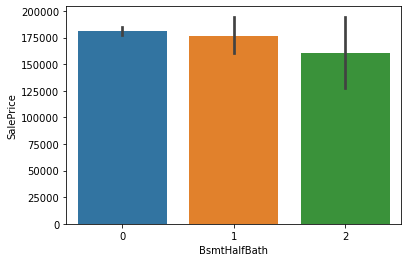

In [105]:
sns.barplot(data = train_data,x='BsmtHalfBath',y='SalePrice')

### FullBath

In [106]:
train_data['FullBath'].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

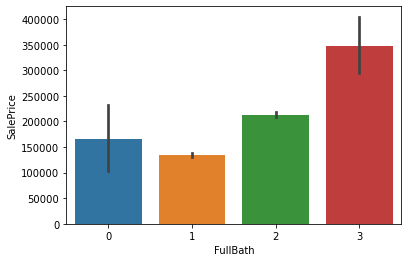

In [107]:
sns.barplot(data = train_data,x='FullBath',y='SalePrice')

### HalfBath

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice'>

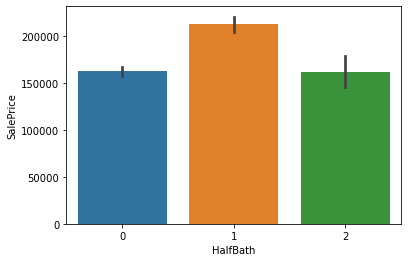

In [108]:
sns.barplot(data = train_data,x='HalfBath',y='SalePrice')

## BedroomAbvGr

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

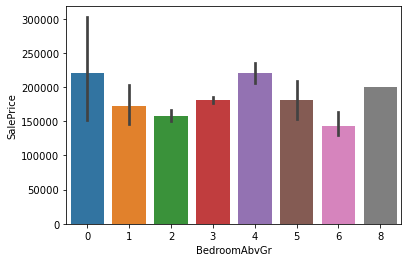

In [109]:
sns.barplot(data = train_data,x='BedroomAbvGr',y='SalePrice')

## Kitchen

### KitchenAbvGr

<AxesSubplot:xlabel='KitchenAbvGr', ylabel='SalePrice'>

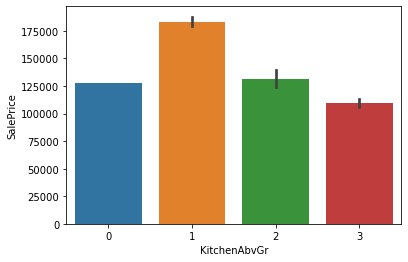

In [110]:
sns.barplot(data = train_data,x='KitchenAbvGr',y='SalePrice')

### KitchenQual

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

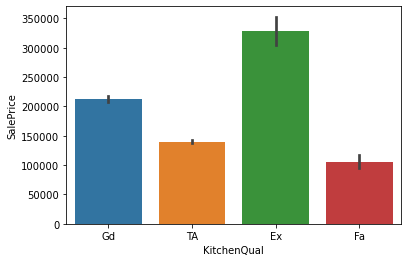

In [111]:
sns.barplot(data = train_data,x='KitchenQual',y='SalePrice')

## TotRmsAbvGrd (does not include bathrooms)

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

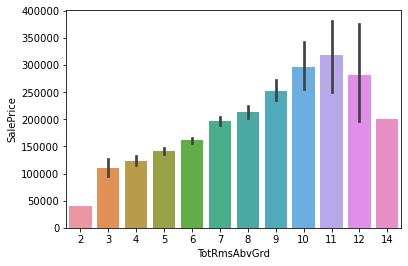

In [112]:
sns.barplot(data = train_data,x='TotRmsAbvGrd',y='SalePrice')

## Home functionality

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

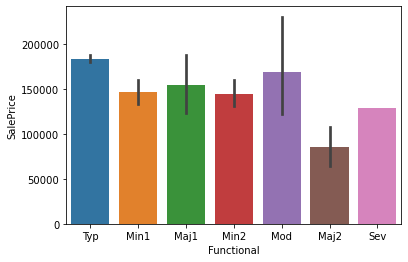

In [113]:
sns.barplot(data = train_data,x='Functional',y='SalePrice')

## FirePlace

### Fireplaces : Number of fireplaces

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

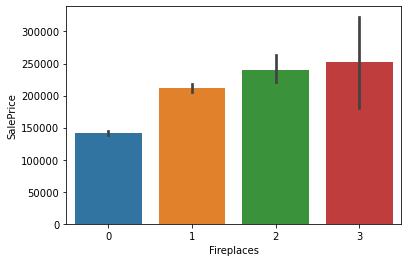

In [114]:
sns.barplot(data = train_data,x='Fireplaces',y='SalePrice')

### FireplaceQual

In [115]:
train_data['FireplaceQu'].isna().sum()
train_data['FireplaceQu'].fillna("0",inplace=True)

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

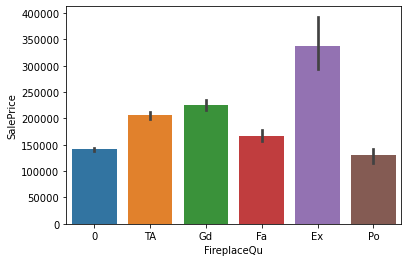

In [116]:
sns.barplot(data = train_data,x='FireplaceQu',y='SalePrice')

## Garage: has NAN

### GarageType

In [117]:
train_data['GarageType'] = train_data['GarageType'].fillna("0")

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

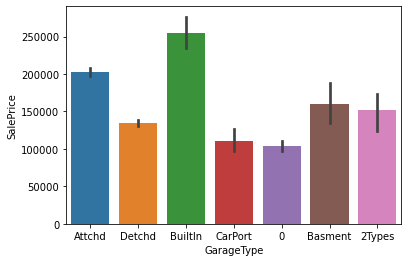

In [118]:
sns.barplot(data = train_data,x='GarageType',y='SalePrice')

### GarageYrBlt

In [119]:
train_data['GarageYrBlt'].fillna(0,inplace = True)

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

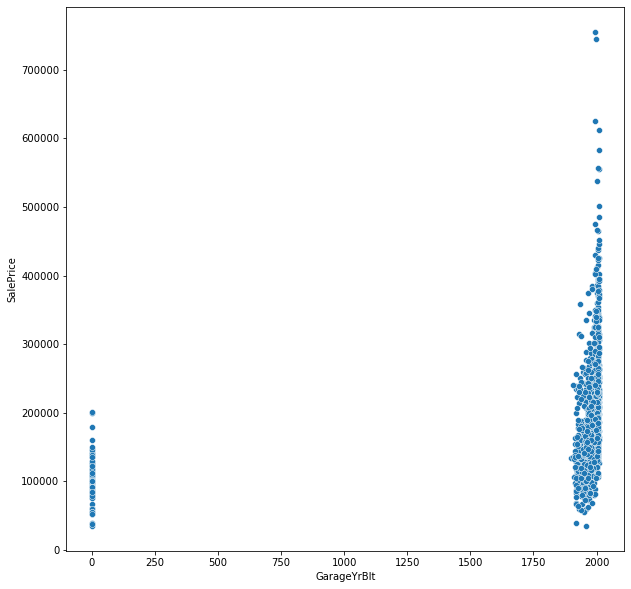

In [120]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GarageYrBlt',y='SalePrice')

### GarageFinish

In [121]:
train_data['GarageFinish'].fillna("0",inplace=True)

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

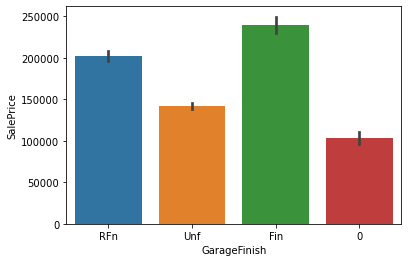

In [122]:
sns.barplot(data = train_data,x='GarageFinish',y='SalePrice')

### GarageCars

In [123]:
train_data['GarageCars'].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

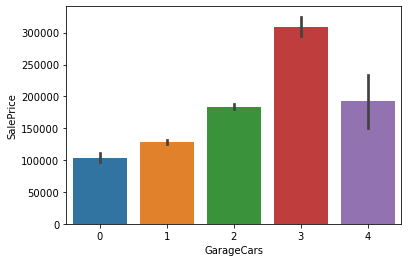

In [124]:
sns.barplot(data= train_data,x='GarageCars',y='SalePrice')

### GarageArea

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

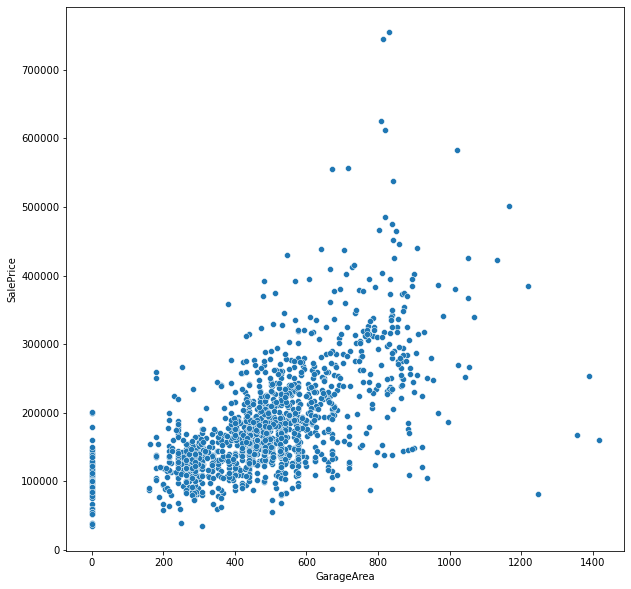

In [125]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='GarageArea',y='SalePrice')

### GarageQual

In [126]:
train_data['GarageQual'].fillna("0",inplace=True)

<AxesSubplot:xlabel='GarageQual', ylabel='SalePrice'>

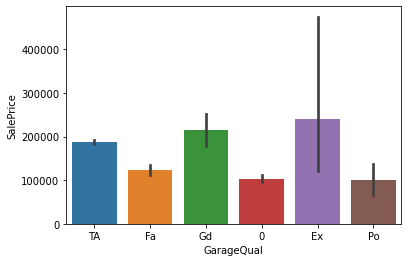

In [127]:
sns.barplot(data = train_data,x='GarageQual',y='SalePrice')

### GarageCond

In [128]:
train_data['GarageCond'].fillna("0",inplace=True)

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

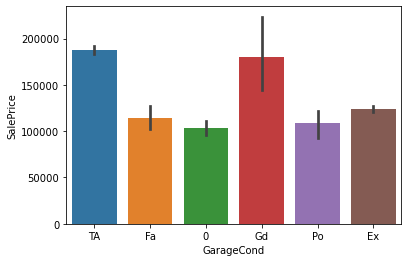

In [129]:
sns.barplot(data= train_data,x='GarageCond',y='SalePrice')

## PavedDrive: Paved driveway

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

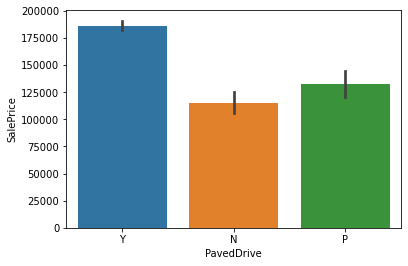

In [130]:
sns.barplot(data = train_data,x='PavedDrive',y='SalePrice')

## WoodDeckSF: a wooden floor built outside, where people can sit and relax


<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

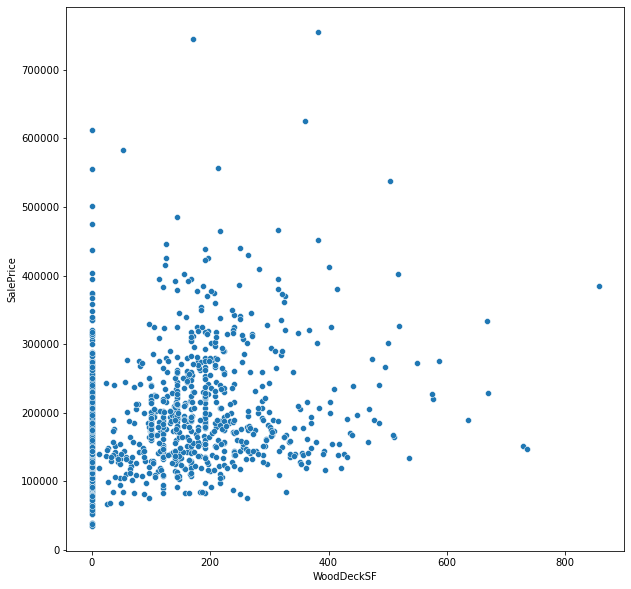

In [131]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='WoodDeckSF',y='SalePrice')

In [132]:
train_data['WoodDeckSF'] = train_data['WoodDeckSF'].apply(lambda x: ScaleNotChangePrice('WoodDeckSF',x) if x > 800 else x)

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

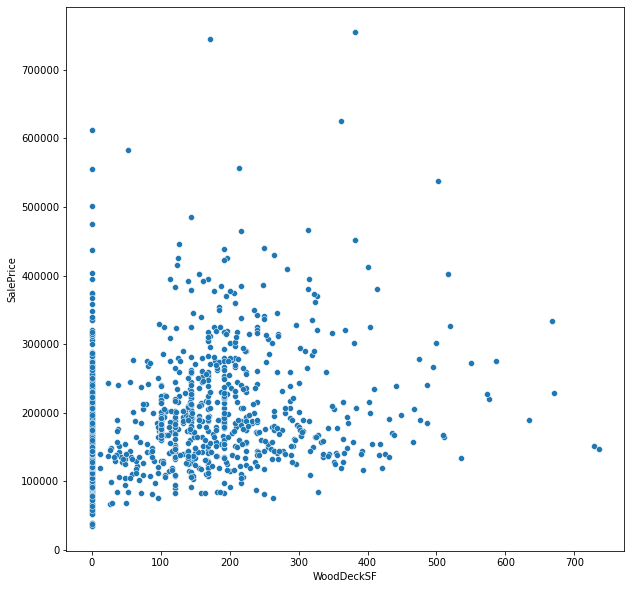

In [133]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='WoodDeckSF',y='SalePrice')

## OpenPorchSF: Open porch area in square feet

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice'>

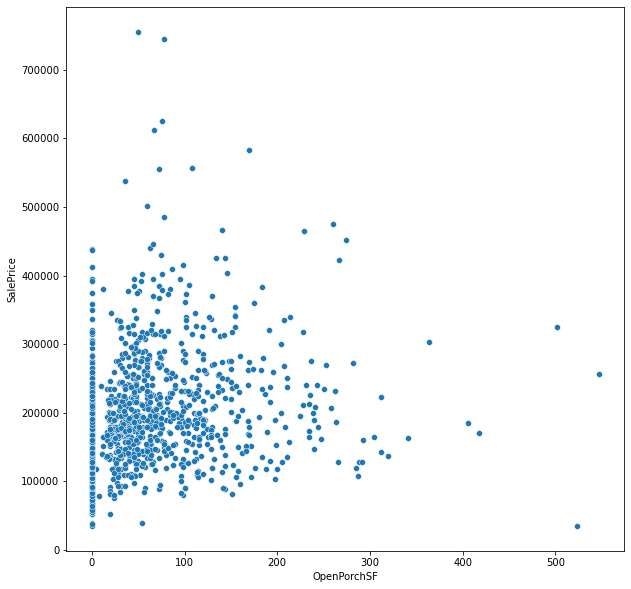

In [134]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='OpenPorchSF',y='SalePrice')

In [135]:
train_data['OpenPorchSF'] = train_data['OpenPorchSF'].apply(lambda x: ScaleNotChangePrice('OpenPorchSF',x) if x > 500 else x)

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice'>

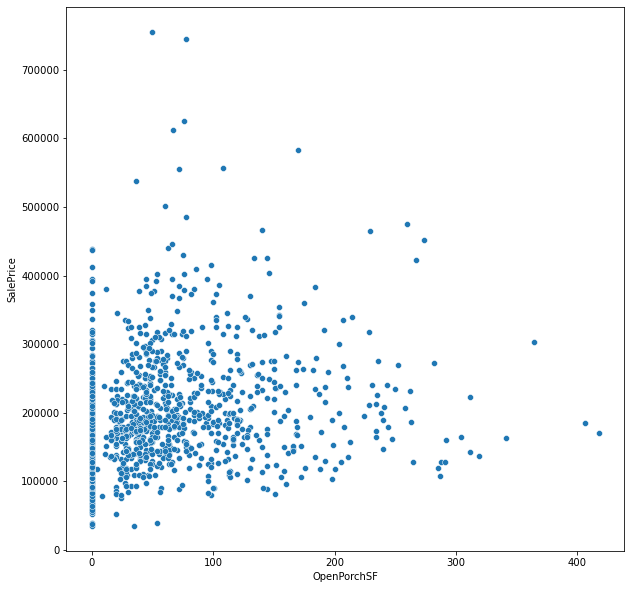

In [136]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='OpenPorchSF',y='SalePrice')

## EnclosedPorch: Enclosed porch area in square feet


<AxesSubplot:xlabel='EnclosedPorch', ylabel='SalePrice'>

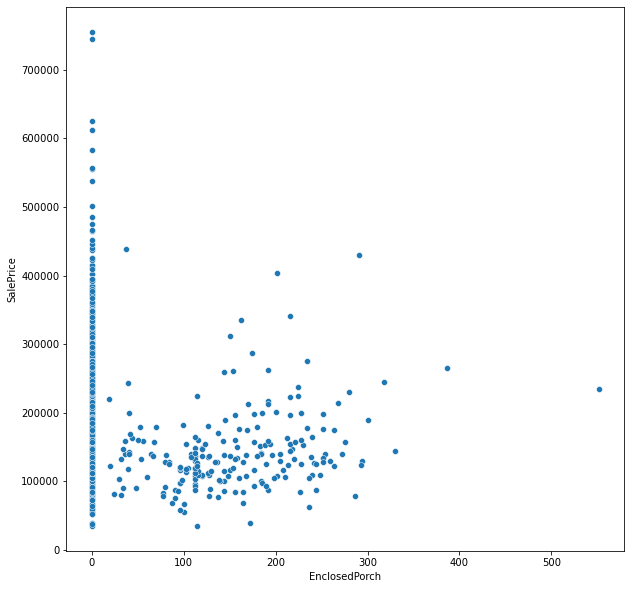

In [137]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='EnclosedPorch',y='SalePrice')

In [138]:
train_data['EnclosedPorch'] = train_data['EnclosedPorch'].apply(lambda x: ScaleNotChangePrice('EnclosedPorch',x) if x > 350 else x)

<AxesSubplot:xlabel='EnclosedPorch', ylabel='SalePrice'>

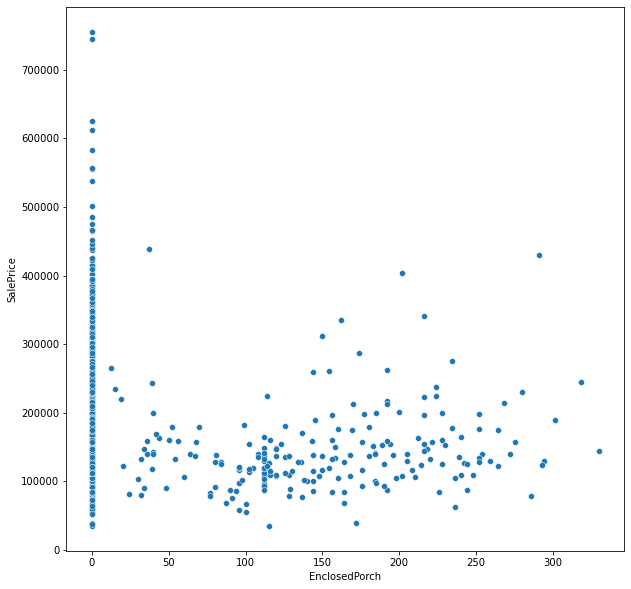

In [139]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='EnclosedPorch',y='SalePrice')

## 3SsnPorch: Three season porch area in square feet

<AxesSubplot:xlabel='3SsnPorch', ylabel='SalePrice'>

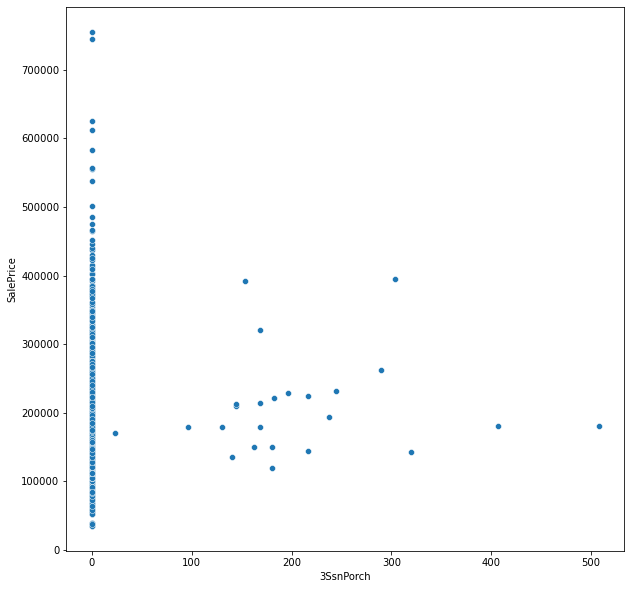

In [140]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='3SsnPorch',y='SalePrice')

In [141]:
train_data['3SsnPorch'] = train_data['3SsnPorch'].apply(lambda x: ScaleNotChangePrice('3SsnPorch',x) if x > 350 else x)

<AxesSubplot:xlabel='3SsnPorch', ylabel='SalePrice'>

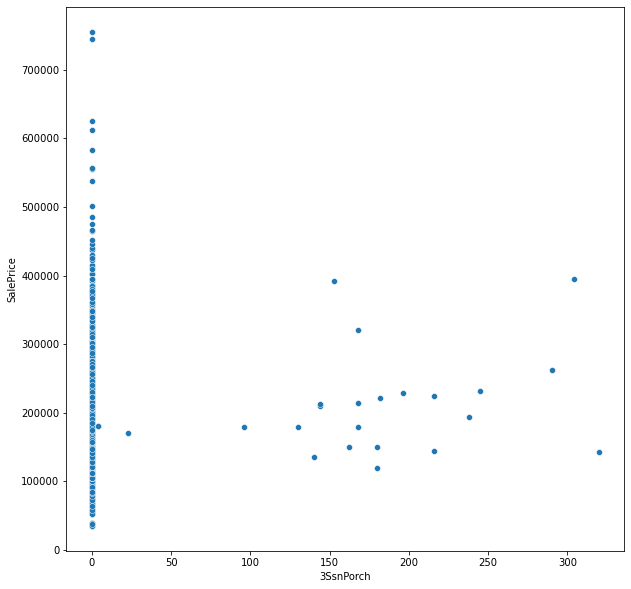

In [142]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='3SsnPorch',y='SalePrice')

## ScreenPorch: Screen porch area in square feet

<AxesSubplot:xlabel='ScreenPorch', ylabel='SalePrice'>

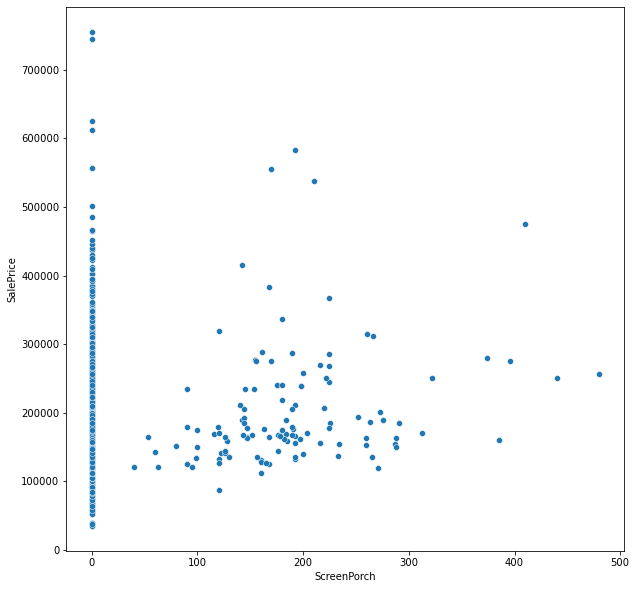

In [143]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train_data,x='ScreenPorch',y='SalePrice')

## Pool

### PoolArea

<AxesSubplot:xlabel='PoolArea', ylabel='SalePrice'>

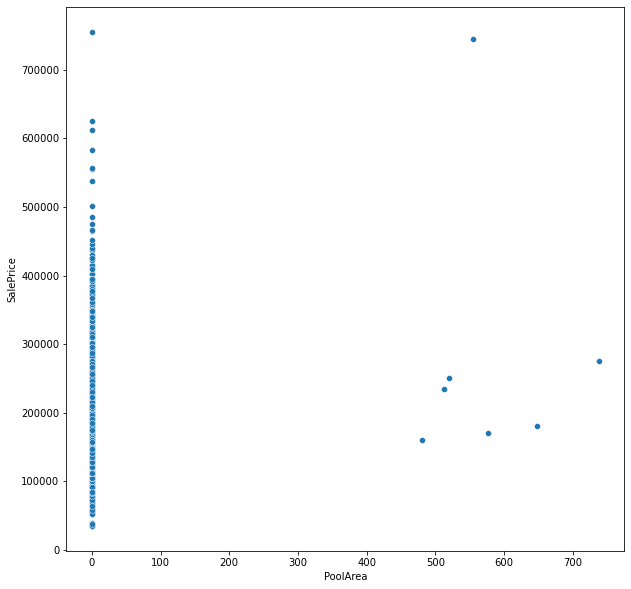

In [144]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = train_data,x='PoolArea',y='SalePrice')

### PoolQC

In [145]:
train_data['PoolQC'] = train_data['PoolQC'].fillna("0")

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

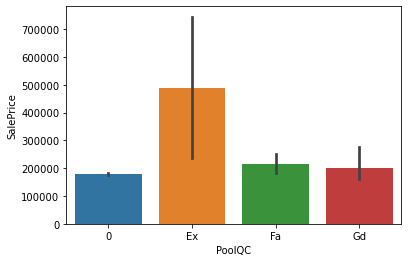

In [146]:
sns.barplot(data = train_data,x='PoolQC',y='SalePrice')

## Fence: Fence quality

In [147]:
train_data['Fence'] = train_data['Fence'].fillna("0")

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

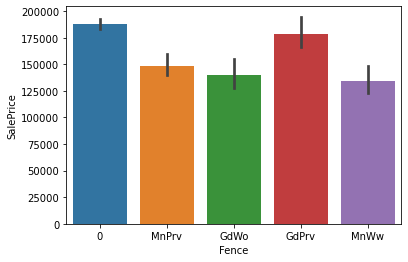

In [148]:
sns.barplot(data = train_data,x='Fence',y='SalePrice')

## Miscellaneous

### MiscFeature: Miscellaneous feature not covered in other categories

In [149]:
train_data['MiscFeature'] = train_data['MiscFeature'].fillna("0")

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

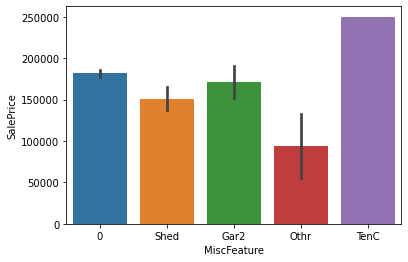

In [150]:
sns.barplot(data = train_data,x='MiscFeature',y='SalePrice')

### MiscVal

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

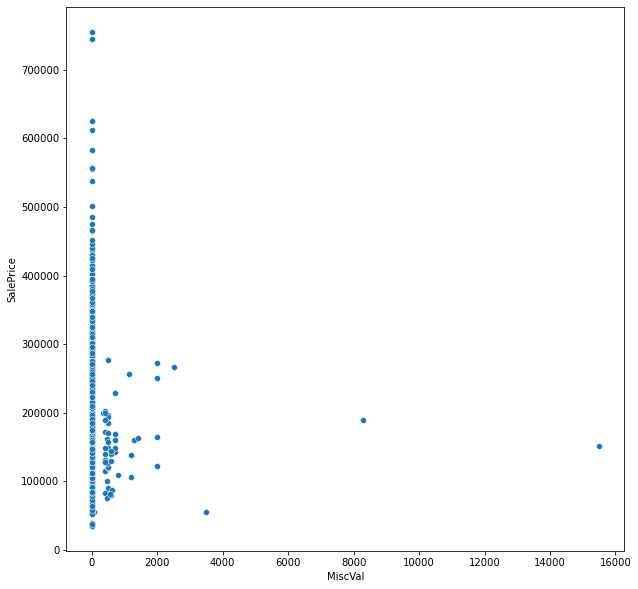

In [151]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MiscVal',y='SalePrice')

In [152]:
train_data['MiscVal'] = train_data['MiscVal'].apply(lambda x: ScaleNotChangePrice('MiscVal',x) if x > 3000 else x)

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

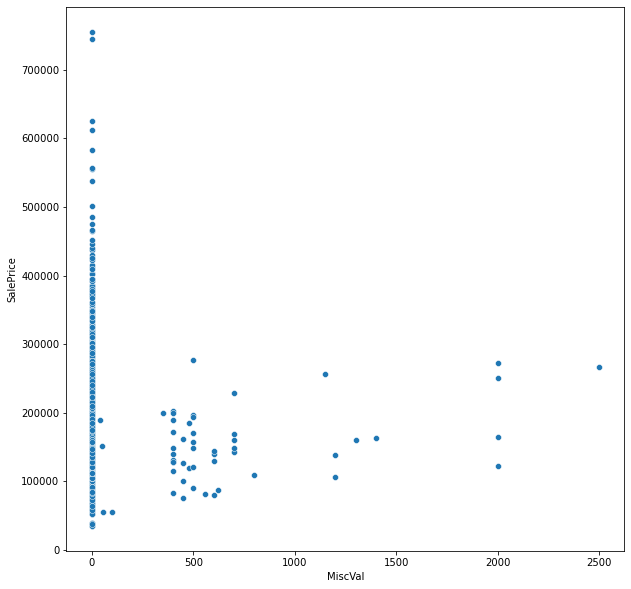

In [153]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x='MiscVal',y='SalePrice')

## Time Sold

### MoSold: Month 

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

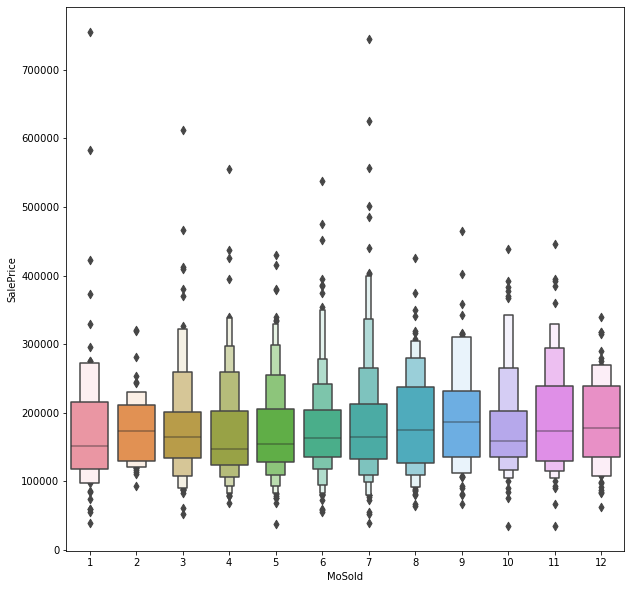

In [154]:
plt.figure(figsize=(10,10))
sns.boxenplot(data = train_data,x='MoSold',y='SalePrice')

### YrSold: Year Sold

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

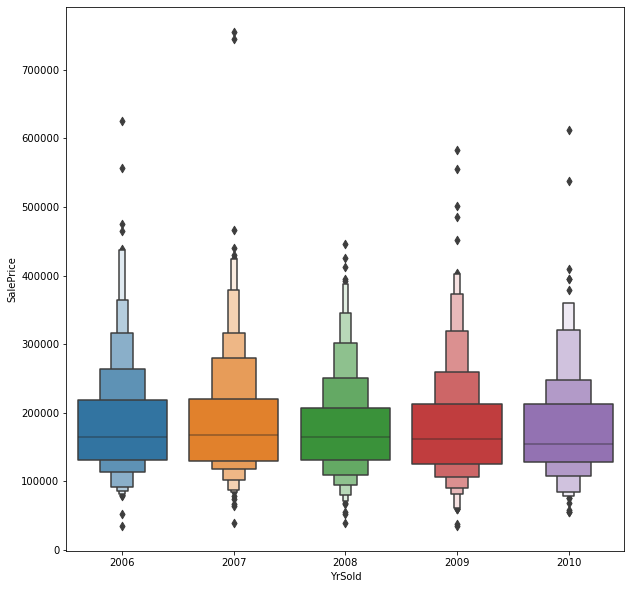

In [155]:
plt.figure(figsize=(10,10))
sns.boxenplot(data = train_data,x='YrSold',y='SalePrice')

## Sale

## SaleType

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice'>

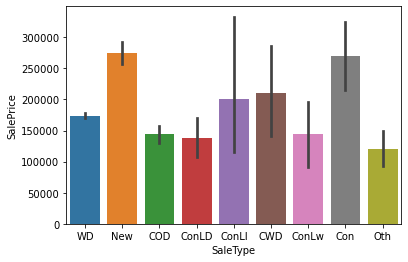

In [156]:
sns.barplot(data = train_data,x='SaleType',y='SalePrice')

## SaleCondition

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

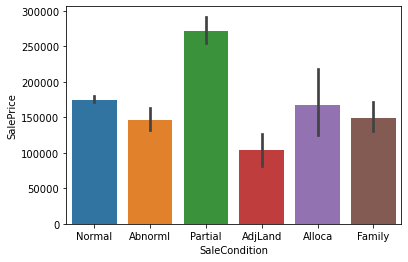

In [157]:
sns.barplot(data = train_data,x='SaleCondition',y='SalePrice')

## Correlation 

In [158]:
train_data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.028478,0.002565,-0.028365,0.012609,-0.012713,-0.021998,-0.047294,-0.016318,...,-0.024327,-0.003217,0.010737,-0.020681,0.001330,0.057044,-0.000303,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.416063,-0.270968,0.032628,-0.059316,0.027850,0.040581,0.023175,-0.073775,...,-0.009645,-0.004153,-0.016553,-0.031008,-0.026030,0.008283,-0.038508,-0.013585,-0.021407,-0.084284
LotFrontage,-0.028478,-0.416063,1.000000,0.466900,0.245231,-0.072166,0.127461,0.078209,0.187804,0.162049,...,0.096245,0.153308,-0.015389,0.057021,0.050231,0.114754,0.006947,0.014576,0.005462,0.381056
LotArea,0.002565,-0.270968,0.466900,1.000000,0.179544,-0.020939,0.041668,0.036868,0.158720,0.209288,...,0.199347,0.174282,-0.025092,0.049827,0.095613,0.142125,0.017491,-0.002990,-0.030617,0.357501
OverallQual,-0.028365,0.032628,0.245231,0.179544,1.000000,-0.091932,0.572323,0.550684,0.417971,0.228002,...,0.234498,0.322493,-0.129975,0.028623,0.064886,0.065166,-0.041168,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.072166,-0.020939,-0.091932,1.000000,-0.375983,0.073741,-0.128612,-0.044203,...,-0.001542,-0.052110,0.076477,0.044672,0.054811,-0.001985,0.092170,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.127461,0.041668,0.572323,-0.375983,1.000000,0.592855,0.320012,0.251461,...,0.226572,0.229021,-0.378644,0.032226,-0.050364,0.004950,-0.066750,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.078209,0.036868,0.550684,0.073741,0.592855,1.000000,0.181075,0.125405,...,0.207953,0.253754,-0.207118,0.063545,-0.038740,0.005829,-0.034871,0.021490,0.035743,0.507101
MasVnrArea,-0.047294,0.023175,0.187804,0.158720,0.417971,-0.128612,0.320012,0.181075,1.000000,0.248441,...,0.170829,0.148993,-0.109528,0.022027,0.044934,0.012582,-0.024974,-0.005785,-0.003272,0.481879
BsmtFinSF1,-0.016318,-0.073775,0.162049,0.209288,0.228002,-0.044203,0.251461,0.125405,0.248441,1.000000,...,0.197680,0.095034,-0.112617,0.048386,0.067200,0.049833,0.014620,-0.000342,0.013908,0.407051


In [159]:
_set = set()
for i in list(train_data.corr()):
    temp = dict(train_data.corr()[i])
    arr = []
    for key,value in temp.items():
        if ((value >= 0.3 and value < 1) or (value <=-0.3 and value > -1)):
            _set.add((i,key,value))

In [160]:
lst = []
for i in _set:
    lst.append(list(i))

In [161]:
index_first = 0
_len = len(lst)
while (index_first < _len):
    index_second = 0
    while (index_second < _len - 1 and index_first < _len):
        if lst[index_first][0] == lst[index_second][1] and lst[index_first][1] == lst[index_second][0]:
            lst.remove([lst[index_second][0],lst[index_second][1],lst[index_second][2]])
            index_second -= 1
            _len -= 1
        index_second += 1
    index_first += 1

In [162]:
lst.sort(key = lambda x:x[2],reverse=True)
lst

[['GarageArea', 'GarageCars', 0.882475414281462],
 ['TotRmsAbvGrd', 'GrLivArea', 0.8237795183280829],
 ['TotalBsmtSF', '1stFlrSF', 0.8073411326882965],
 ['OverallQual', 'SalePrice', 0.7909816005838053],
 ['SalePrice', 'GrLivArea', 0.734977688553035],
 ['2ndFlrSF', 'GrLivArea', 0.6924387552244028],
 ['TotRmsAbvGrd', 'BedroomAbvGr', 0.676619935742649],
 ['BsmtFullBath', 'BsmtFinSF1', 0.6553705354433607],
 ['TotalBsmtSF', 'SalePrice', 0.6457533029324867],
 ['GarageCars', 'SalePrice', 0.6404091972583519],
 ['GrLivArea', 'FullBath', 0.6368256708715182],
 ['SalePrice', '1stFlrSF', 0.6256703378652645],
 ['GarageArea', 'SalePrice', 0.6234314389183622],
 ['TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431],
 ['HalfBath', '2ndFlrSF', 0.6097073002717436],
 ['OverallQual', 'GarageCars', 0.6006707165907149],
 ['GarageYrBlt', 'GarageCars', 0.5980046450202292],
 ['YearBuilt', 'YearRemodAdd', 0.5928549763436519],
 ['OverallQual', 'GrLivArea', 0.5859788488490348],
 ['OverallQual', 'YearBuilt', 0.5723227689

### Garage

In [163]:
garages =  []
for i in list(train_data):
    if rg.search("^Garage",i) or rg.search("Garage$",i):
        garages.append(i)
print(garages)

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


In [164]:
sort_garage = []
for garage in garages:
    for i in lst:
        if garage in i and i not in sort_garage:
            sort_garage.append(i)
sort_garage.sort(key = lambda x:x[2],reverse = True)
sort_garage

[['GarageArea', 'GarageCars', 0.882475414281462],
 ['GarageCars', 'SalePrice', 0.6404091972583519],
 ['GarageArea', 'SalePrice', 0.6234314389183622],
 ['OverallQual', 'GarageCars', 0.6006707165907149],
 ['GarageYrBlt', 'GarageCars', 0.5980046450202292],
 ['GarageArea', 'OverallQual', 0.5620217566126083],
 ['GarageYrBlt', 'GarageArea', 0.5607828699762403],
 ['YearBuilt', 'GarageCars', 0.5378500917111052],
 ['GarageArea', 'YearBuilt', 0.4789538198934904],
 ['GarageArea', '1stFlrSF', 0.47543112603228993],
 ['GrLivArea', 'GarageCars', 0.4750530226936641],
 ['GarageArea', 'TotalBsmtSF', 0.47342764919758146],
 ['GarageCars', 'FullBath', 0.469672043267628],
 ['GarageCars', 'TotalBsmtSF', 0.4532012960265513],
 ['GrLivArea', 'GarageArea', 0.45219743913782656],
 ['GarageCars', '1stFlrSF', 0.4503926414211144],
 ['YearRemodAdd', 'GarageCars', 0.42062215494321714],
 ['GarageArea', 'FullBath', 0.4056562084540099],
 ['GarageArea', 'MasVnrArea', 0.3804419202479155],
 ['GarageCars', 'MasVnrArea', 0.372

# Feature Importance

In [165]:
train_data.drop(columns= "Id")

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0.0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600.0,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0.0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250.0,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0.0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550.0,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0.0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260.0,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0.0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917.0,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0.0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175.0,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,0,0.0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042.0,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,GdPrv,Shed,2500.0,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717.0,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0.0,4,2010,WD,Normal,142125


In [267]:
y_train = train_data['SalePrice']
x_train = train_data.drop(columns=["Id","SalePrice"])

In [259]:
num = (list(x_train.describe()))
cate = []
for attr in list(x_train):
    if attr not in num:
        cate.append(attr)

In [268]:
num_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy='mean')),#use gridsearch
    ("scaler",StandardScaler())
])

In [269]:
cate_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OrdinalEncoder())
])

In [270]:
prepare_pipeline = ColumnTransformer([
    ("num",num_pipeline,num),
    ("cate",cate_pipeline,cate)
])

In [272]:
x_train = prepare_pipeline.fit_transform(x_train)

In [248]:
sgd_reg = SGDRegressor()

In [232]:
param_grid = {
    "penalty": ["l2","l1","elasticnet"],
    "alpha": [0.0000001*i for i in range(1,71,10)],
    "learning_rate": ["constant",'optimal','invscaling','adaptive'],
    "early_stopping": [False,True]
}

In [233]:
grid_search = GridSearchCV(sgd_reg,param_grid=param_grid,cv = 10,scoring='neg_mean_squared_error',verbose = 2,refit=True)
grid_search.fit(x_train,y_train)

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, learning_rate=constant, penalty=l2; total time=   0.0s
[CV] END alpha=1e-07, early_stopping=False, 

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid={'alpha': [1e-07, 1.1e-06, 2.1e-06, 3.1e-06, 4.1e-06,
                                   5.0999999999999995e-06, 6.1e-06],
                         'early_stopping': [False, True],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='neg_mean_squared_error', verbose=2)

In [235]:
new_sgd = SGDRegressor(**grid_search.best_params_)

In [236]:
new_sgd.fit(x_train,y_train)

SGDRegressor(alpha=1e-07)

In [296]:
param_grid_random = {
    # "n_estimators":[i for i in range(100,150)],
    "criterion":['mse','mae'],
    'max_features':['auto','sqrt','log2']
}

In [297]:
random_forest_reg = RandomForestRegressor()

In [298]:
grid_search = GridSearchCV(random_forest_reg,param_grid=param_grid_random,cv = 10,scoring='neg_mean_squared_error',verbose = 2,refit=True)
grid_search.fit(x_train,y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.6s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.3s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.4s
[CV] END ...................criterion=mse, max_features=auto; total time=   1.5s
[CV] END ...................criterion=mse, max_features=sqrt; total time=   0.2s
[CV] END ...................criterion=mse, max_f

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=2)

In [311]:
sorted(grid_search.best_estimator_.feature_importances_)

[0.0,
 2.6530349140400373e-05,
 0.0001994319393538144,
 0.0003301005731414811,
 0.00034723924167070206,
 0.0003498079949672384,
 0.00036145028925211085,
 0.0003668703856008995,
 0.00045015490545372055,
 0.0005025007340420165,
 0.0007453123305280132,
 0.000831960657080959,
 0.0008875591753855939,
 0.0009758906206901347,
 0.0009951067790923745,
 0.0012316636942102748,
 0.001393079321060749,
 0.0014867254674224186,
 0.0014911557885443102,
 0.001508445095148805,
 0.0015765205571336368,
 0.0015851575895055702,
 0.0016198604807544973,
 0.0018519106851573406,
 0.0018764662037165107,
 0.001945062855586711,
 0.0020371450237373573,
 0.002216609761964705,
 0.002323592555413535,
 0.0023318355441905993,
 0.0023756181715849423,
 0.0024084149659265026,
 0.00254736578874347,
 0.0026611143997432173,
 0.0026858461642853882,
 0.0026866893846832166,
 0.00270212905397647,
 0.002719420337094257,
 0.0027799710480384326,
 0.0029267886209087685,
 0.003045842711265564,
 0.0031482438753676753,
 0.003367525715350

In [307]:
random_forest_reg = RandomForestRegressor(**grid_search.best_params_)
random_forest_reg.fit(x_train,y_train)

RandomForestRegressor(criterion='mae')

In [299]:
test = load_csv(path,"test.csv")

In [300]:
test.drop(columns="Id",inplace=True)

In [301]:
test_set = prepare_pipeline.transform(test)

In [308]:
test_predict = random_forest_reg.predict(test_set)

In [309]:
submit = pd.DataFrame({"Id":[i+1461 for i in range(len(test_set))],"SalePrice":test_predict})
submit.to_csv("submit.csv",index=False)